In [30]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
import pandas as pd
from src import TwoAgents as ta
from src import helperfunctions as hf

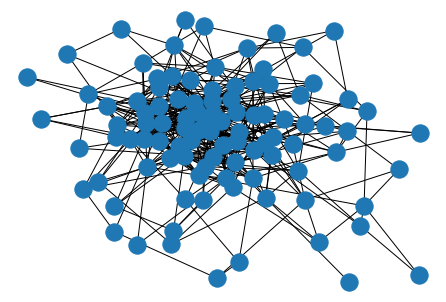

In [31]:
def average_degree(system,control,budget):
    return abs(np.sum([system.graph.degree[i]*con for i,con in enumerate(control)])/budget)



sizes = [50,50] # sizes of blocks
probs = [[0.2, 0.05], [0.05, 0.05]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

nx.draw(G)

# G.graph['partition'][1] get nodes from 2nd stochastic block

In [98]:
import networkx as nx 
import numpy as np
import math  



def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.abs(np.sort(v)[::-1])
    cssv = np.cumsum(u) - z
    
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0

    try:
        rho = ind[cond][-1]
    except IndexError:
        print(ind)
        print(ind[cond])
        sys.exit()
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w



class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=int(5*1e4),init_mag='random',fp_tol_fac=1e-5,
                 iim_iter=5000,iim_tol_fac=1e-4,**kwargs):
        
        self.graph = graph
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        for k, v in kwargs.items():
            if not hasattr(self,k):
                setattr(self, k, v)
            
        if init_mag=='random':
            self.init_mag=np.array([np.random.choice([-1,1]) for i in range(self.graph_size)])
        else:
            self.init_mag = init_mag 
   
        
    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = np.dot(self.adj_matrix[i],m)
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term
    
    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(self.graph_size):
            m_new[i]=self.single_mag(i,m_old,beta,field)
        return m_new

    def aitken_method(self,mag0,beta,field):      
        # Numerical Analysis Richard L.Burden 9th Edition, p. 105
        
        mag1=self.magnetisation(mag0,beta,field)
        for i in range(self.fixed_point_iter):     
            mag2=self.magnetisation(mag1,beta,field)   
            if np.all((mag0+mag2-2*mag1)!=0):
                mag_d = mag0 - (mag1-mag0)**2/(mag0+mag2-2*mag1) 
            else:
                mag_d = mag1
            
            if abs(np.sum(mag0)-np.sum(mag_d))<self.fp_tol_fac: 
                break
            mag0=mag1
            mag1=mag2
            if i+1==self.fixed_point_iter:
                print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter')
                mag_d = mag1
 
        if any(np.isnan(mag_d)):
                print(mag0)
                print(field)
                sys.exit()
        return mag_d
    
    def mag_grad(self,beta,mag):
        # Mean Field Susceptibility;
        
        if all([math.isclose(i,j,abs_tol=1e-5) for i,j in zip(mag,np.ones(len(mag)))]):
            gradient = np.zeros(len(mag))
        else:
            D=np.identity(self.graph_size)*np.array([(1-i**2) for i in mag]) # equals to 0 if all m's are 1 or close to 1
            inv = np.linalg.inv(np.identity(self.graph_size)-beta*D*self.adj_matrix)
            susc_matrix = beta*inv*D
            gradient = np.sum(susc_matrix,axis=1).A1
        return gradient
    
    def positive_agent(self,mag_i,it,pos_budget,beta):
        # maximising positive of magnetisation
        mag_i_grad = self.mag_grad(beta,mag_i)
        self.gradient_history_pos.append(mag_i_grad)
        control_field = self.control_field_history_pos[it]
        gradient = mag_i_grad
        if self.optimiser_type=='sgd':
            control_field_update = control_field + self.lr_1(it,self.iim_iter)*gradient
        else:
            method = getattr(self,self.optimiser_type)
            control_field_update = control_field + method(mag_i_grad,'pos',it)
            
        control_field_new = projection_simplex_sort(control_field_update.T,z=pos_budget)
        self.control_field_history_pos.append(control_field_new)
        
        return control_field_new,gradient
    
    
    def negative_agent(self,mag_i,it,neg_budget,beta):
        # maximising negative of magnetisation
        mag_i = -1.0*mag_i
        mag_i_grad = -self.mag_grad(beta,mag_i) # minus because product rule: since H_tot = H_pos - H_neg
        self.gradient_history_neg.append(mag_i_grad)
        control_field = self.control_field_history_neg[it]
        gradient = mag_i_grad
        if self.optimiser_type=='sgd':
            control_field_update = control_field + self.lr_2(it,self.iim_iter)*gradient
        else:
            method = getattr(self,self.optimiser_type)
            control_field_update = control_field +  method(mag_i_grad,'neg',it)
            
        control_field_new = projection_simplex_sort(control_field_update.T,z=neg_budget)
        self.control_field_history_neg.append(control_field_new)
        
        return control_field_new,gradient
    
    def sgdm(self,grad,typ,it):
        if typ=='pos':
            step_size=self.lr_1(it,self.iim_iter)
            name='changes_pos'
        elif typ=='neg':
            step_size=self.lr_2(it,self.iim_iter)
            name='changes_neg'

        new_change = step_size * grad + self.momentum * getattr(self,name)[-1]
        getattr(self,name).append(new_change)
        return new_change
     
    def adagrad(self,grad,typ,it):
        if typ=='pos':
            step_size=self.lr_1(it,self.iim_iter)
            name='grad_sums_pos'
        elif typ=='neg':
            step_size=self.lr_2(it,self.iim_iter)
            name='grad_sums_neg'
        grad_sums = getattr(self,name) 
        grad_sums += grad**2
        alpha = step_size / (1e-8 + np.sqrt(grad_sums))
        change = alpha*grad
        setattr(self,name,grad_sums)
        return change
    
    def adadelta(self,grad,typ,it,ep=1e-4):
        if typ=='pos':
            rho=self.rho1
            name1='grad_sums_pos'
            name2='para_pos'
        elif typ=='neg':
            rho=self.rho2
            name1='grad_sums_neg'
            name2='para_neg'
        sg = grad**2
        grad_avg = getattr(self,name1) 
        para_avg = getattr(self,name2)
        grad_avg_new= (grad_avg * rho) + (sg * (1.0-rho))
        alpha = (ep + np.sqrt(para_avg)) / (ep + np.sqrt(grad_avg_new))
        change = alpha*grad
        setattr(self,name1,grad_avg_new)
        para_avg_new = (para_avg * rho) + (change**2.0 * (1.0-rho))
        setattr(self,name2,para_avg_new)
        return change
    
    def adam(self,grad,typ,it):
        if typ=='pos':
            lr=self.lr_1(it,self.iim_iter)
            name1='ms_pos'
            name2='vs_pos'
        elif typ=='neg':
            lr=self.lr_2(it,self.iim_iter)
            name1='ms_neg'
            name2='vs_neg'
        ms_previous = getattr(self,name1)
        vs_previous = getattr(self,name2)
        if not (hasattr(self,'beta1') and hasattr(self,'beta2') and hasattr(self,'eps') ):
            self.beta1=0.9
            self.beta2=0.99
            self.eps=1e-5
        ms_new = self.beta1 * ms_previous + (1.0 - self.beta1) * grad
        vs_new = self.beta2 * vs_previous + (1.0 - self.beta2) * grad**2
        mhat = ms_new / (1.0 - self.beta1**(it+1))
        vhat = vs_new / (1.0 - self.beta2**(it+1))
        setattr(self,name1,ms_new)
        setattr(self,name2,vs_new)
        change = lr* mhat/(np.sqrt(vhat) + self.eps)
        return change
    

    def second_partial_dffs(self,mag_ii,tot_field,control_pos,control_neg,a=1e-5):
        ' estimating 2nd partial derivative with respect to each agents external field' 
        
        ' gradient for negative '
        update = a*np.ones(system.graph_size)
        upper_change=tot_field+update
        mag_plus= -self.aitken_method(mag_ii,beta,upper_change)
        grad_plus = -self.mag_grad(beta,mag_plus)

        lower_change = tot_field-update
        mag_minus= -self.aitken_method(mag_ii,beta,lower_change)
        grad_minus = -self.mag_grad(beta,mag_minus)
        second_total_grad =  (grad_plus - grad_minus)/(2*update) # central difference formula
        curv_player_neg = - second_total_grad # minus because product rule : H_pos = H_pos - H_neg
        self.grad2neg.append(curv_player_neg)
        
        'gradient for positive'
        upper_change=tot_field+update
        mag_plus= self.aitken_method(mag_ii,beta,upper_change)
        grad_plus = self.mag_grad(beta,mag_plus)

        lower_change = tot_field-update
        mag_minus= self.aitken_method(mag_ii,beta,lower_change)
        grad_minus = self.mag_grad(beta,mag_minus)
        second_total_grad = (grad_plus - grad_minus)/(2*update) # central difference formula
        curv_player_pos = second_total_grad
        self.grad2pos.append(curv_player_pos)
        return np.array([curv_player_pos,curv_player_neg])
    
    def init_optimiser(self,optimiser_type):
        if self.optimiser_type=='sgdm':
            self.changes_pos = [np.zeros(self.graph_size)]
            self.changes_neg = [np.zeros(self.graph_size)]
        if any(t==self.optimiser_type for t in ['adagrad','adadelta']):
            self.grad_sums_pos = np.zeros(self.graph_size)
            self.grad_sums_neg = np.zeros(self.graph_size)
            self.para_pos=np.zeros(self.graph_size)
            self.para_neg = np.zeros(self.graph_size)
        if optimiser_type=='adam':
            self.ms_pos = np.zeros(self.graph_size)
            self.vs_pos = np.zeros(self.graph_size)
            self.ms_neg = np.zeros(self.graph_size)
            self.vs_neg = np.zeros(self.graph_size)

        
    def MF_IIM(self,pos_budget,neg_budget,beta,init_alloc='random'):
              
        if init_alloc=='aligned':
            control_field_pos =( pos_budget /self.graph_size)*np.ones(self.graph_size)
            control_field_neg = ( neg_budget /self.graph_size)*np.ones(self.graph_size)
        elif init_alloc=='random':
            control_field_pos  = np.random.dirichlet(np.ones(self.graph_size))*pos_budget
            control_field_neg  = np.random.dirichlet(np.ones(self.graph_size))*neg_budget
        else: # if provided as an argument
            control_field_pos = init_alloc[0,:]
            control_field_neg = init_alloc[1,:]
            
  
        tot_field = np.array(self.background_field+control_field_pos-control_field_neg)

        self.control_field_history_pos = []
        self.control_field_history_neg = []
        self.gradient_history_pos = []
        self.gradient_history_neg = []
        self.mag_delta_history = []
        self.total_field =[]

        self.total_field.append(tot_field)
        self.control_field_history_pos.append(control_field_pos)
        self.control_field_history_neg.append(control_field_neg)
        
        mag_i = self.aitken_method(self.init_mag,beta,tot_field)
        self.grad2pos =[]
        self.grad2neg =[]   
        self.init_optimiser(self.optimiser_type)
        self.converged=False
        for it in range(self.iim_iter):
            
            control_pos,pos_gradient = self.positive_agent(mag_i,it,pos_budget,beta)
            
            control_neg,neg_gradient = self.negative_agent(mag_i,it,neg_budget,beta)
                                    
            tot_field = np.array(self.background_field-control_neg+control_pos)
            self.total_field.append(tot_field)
            mag_ii= self.aitken_method(mag_i,beta,tot_field)
            self.mag_delta_history.append(mag_ii)

            
            second_dffs=self.second_partial_dffs(mag_ii,tot_field,control_pos,control_neg) 

            if (all(np.abs(pos_gradient))<self.iim_tol_fac and all(np.abs(neg_gradient))<self.iim_tol_fac and 
                all(second_dffs[0]<0) and all(second_dffs[1]<0) ):
                self.converged=True
                break
            
            mag_i=mag_ii
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations'.format(self.iim_iter))
            #print('pos_gradient',pos_gradient)
            #print('neg_gradient',neg_gradient)
            final_mag = mag_ii
            
        elif it < self.iim_iter-1:
            print('iteration',it)
            final_mag = mag_ii
        
        self.control_field_history_pos = np.array(self.control_field_history_pos)
        self.control_field_history_neg = np.array(self.control_field_history_neg)
        

        return self.control_field_history_pos[-1],self.control_field_history_neg[-1],final_mag

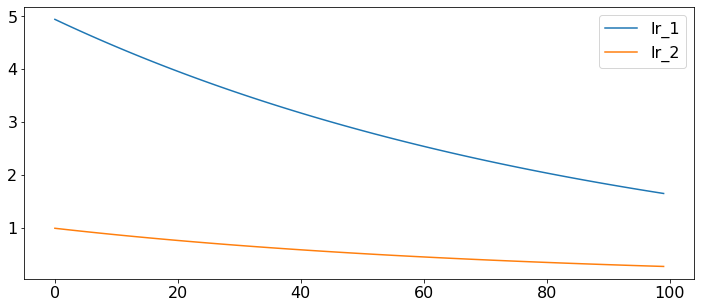

In [104]:
it = np.linspace(1,100,100)

lr_1 = lambda x,maxiter : 5*np.exp(-x/(0.9*maxiter))


lr_2 = lambda x,maxiter : np.exp(-x/(0.75*maxiter))


plt.plot(lr_1(it,100),label='lr_1')

plt.plot(lr_2(it,100),label='lr_2')
plt.legend()


In [109]:
a_pos = np.random.dirichlet(np.ones(50))*0.75*budget_pos 
b_pos =np.random.dirichlet(np.ones(50))*0.25*budget_pos 

init_pos = np.concatenate([a_pos,b_pos])

a_neg = np.random.dirichlet(np.ones(50))*0.75*budget_neg
b_neg =np.random.dirichlet(np.ones(50))*0.25*budget_neg 

init_neg =  np.concatenate([a_neg,b_neg])

init_alloc = np.column_stack([init_pos,init_neg]).T



(2, 100)

In [110]:
b = np.zeros(len(G.nodes.keys()))
budget_pos=20.0
budget_neg=5


params = {'optimiser_type':'adam','lr_1':lr_1,'lr_2':lr_2,'beta1':0.8,'beta2':0.999,'eps':0.5}
system = mf_ising_system(G,b,iim_iter=5000,fixed_point_iter=int(5*1e5),iim_tol_fac=1e-4,**params)


beta=1.3

iters=5
pos_degrees=[]
neg_degrees=[]

for i in range(iters):
    control_pos,control_neg,mag=system.MF_IIM(budget_pos,budget_neg,beta,init_alloc=init_alloc)

    #if system.converged==False:
    #continue # not considering iterations that failed
    controls_pos = system.control_field_history_pos
    controls_neg = system.control_field_history_neg
    temp_pos=[]
    temp_neg=[]
    for idx in range(controls_pos.shape[0]):
        pos_degree = average_degree(system,controls_pos[idx],budget_pos)
        neg_degree = average_degree(system,controls_neg[idx],budget_neg)
        temp_pos.append(pos_degree)
        temp_neg.append(neg_degree)
    
    pos_degrees.append(temp_pos)
    neg_degrees.append(temp_neg)

<ipython-input-98-9817c7774101>:254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_alloc=='aligned':
<ipython-input-98-9817c7774101>:257: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif init_alloc=='random':


Failed to converge after 5000 iterations


KeyboardInterrupt: 

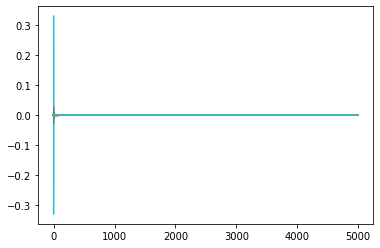

[-2.35477186e-06 -1.41997323e-08  0.00000000e+00 -1.66986118e-16
 -7.21890909e-11 -1.83733034e-16 -1.15552132e-10 -1.14868644e-17
 -4.34322833e-19 -2.37289360e-21 -4.25288167e-19  0.00000000e+00
  0.00000000e+00 -1.02473614e-09 -1.31339404e-09 -9.29869714e-16
 -9.48919975e-17  0.00000000e+00 -7.68653444e-20  0.00000000e+00
 -1.44331536e-11 -1.45546174e-08 -3.97585896e-22  0.00000000e+00
  0.00000000e+00 -2.47767168e-15 -2.87181213e-20 -1.84337019e-07
 -7.82484574e-18 -7.90200131e-18 -2.34924305e-07 -8.66540728e-11
 -7.98976412e-17  0.00000000e+00 -9.86076132e-26 -1.44331395e-11
  0.00000000e+00 -7.21885630e-11  0.00000000e+00  0.00000000e+00
 -4.78233986e-19  0.00000000e+00 -1.22993091e-16  0.00000000e+00
 -8.65995524e-11 -5.96138526e-18 -6.63408387e-18  0.00000000e+00
 -1.64934598e-16 -1.56302158e-16 -4.11397104e-04 -4.11662256e-04
 -5.58493779e-04 -5.58608502e-04 -1.84428568e-07 -1.84547131e-07
 -4.11662245e-04 -3.05739935e-05 -4.11663514e-04 -5.62460832e-04
 -1.14153626e-09 -5.58577

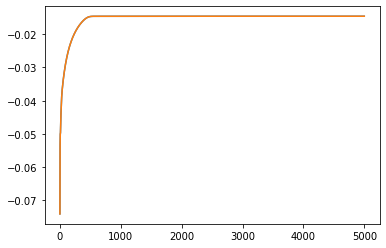

In [78]:
plt.plot(system.gradient_history_pos,label='pos')
plt.plot(system.gradient_history_neg,label='neg')
plt.show()


second_diff=np.sum(np.array(system.grad2pos),axis=1)
plt.plot(second_diff)


print(np.array(system.grad2pos)[-1])
plt.plot(second_diff)



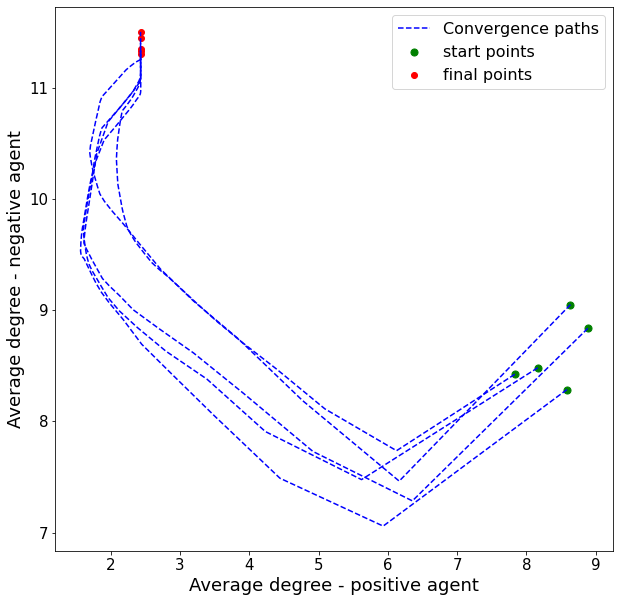

In [82]:
import matplotlib
fig,ax=plt.subplots(figsize=(10,10))

n=1

matplotlib.rcParams.update({'font.size': 16,'figure.figsize':(12,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})

for idx,run in enumerate(pos_degrees):
    
    ax.plot(run[::n],neg_degrees[idx][::n],label='Convergence paths',c='blue',linestyle='dashed')
    ax.set_xlabel('Average degree - positive agent')
    ax.set_ylabel('Average degree - negative agent')
    ax.scatter(run[0],neg_degrees[idx][0],c='green',label='start points',s=50)
    ax.scatter(run[-1],neg_degrees[idx][-1],c='red',label='final points')

    hand, labl = ax.get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    ax.legend(handout, lablout,loc='best')

In [ ]:
budget_pos=5.0

budget_neg=20.0


beta_min = 0.5*beta_crit 
beta_max = 3*beta_crit 

beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=10,endpoint=True,base=10)
control_history_pos=np.zeros((len(beta_list),2))
control_history_neg=np.zeros((len(beta_list),2))
mag_history = np.zeros((len(beta_list),system.graph_size))

normal_params = {'graph':G,'background_field':b,'lr_1':lr_1,'lr_2':lr_2,
                         'iim_iter':10000,'iim_tol_fac':1e-3,'fixed_point_iter':5000,
                         'fp_tol_fac':1e-3,'optimiser_type':'sgdm','momentum':0.7}


for i,beta in enumerate(beta_list):
    
    system = ta.mf_ising_system(**normal_params)
    control_pos,control_neg,final_mag=system.MF_IIM(budget_pos,budget_neg,beta)
    
    block1,block2 = np.sum(control_pos[:50]),np.sum(control_pos[50:])
    control_history_pos[i]=np.array([block1,block2])

    block1,block2 = np.sum(control_neg[:50]),np.sum(control_neg[50:])
    control_history_neg[i]=np.array([block1,block2])
    
    mag_history[i]=final_mag
     
    if i%1==0:
        print(i,beta)

print('FINISHED')    

In [ ]:

X = np.zeros((len(beta_list),2))
for idx,mags in enumerate(mag_history):
    X[idx,0]=sum(x>0 for x in mags)/len(mags)
    X[idx,1]=sum(x<0 for x in mags)/len(mags)

        
        
plt.plot(beta_list,X[:,0],label='positive')
plt.plot(beta_list,X[:,1],label='negative')
plt.xlabel(r'Interaction Strenght $\beta$')
plt.ylabel('share of influenced nodes')
plt.title(r'Budget ratio: $B_{pos}$:$B_{neg}$=2:2',fontsize=20)

plt.legend()

In [ ]:
import matplotlib


matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(12,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})

# to_del =[80,81]
# control_history_edit= np.delete(control_history,to_del,axis=0)
# beta_list_edit = np.delete(beta_list,to_del,axis=0)


fig,ax = plt.subplots(ncols=2)

ax[0].plot(beta_list,control_history_pos[:,0],c='orange',label='Block 1',linestyle='dashed',linewidth=3)
ax[0].plot(beta_list,control_history_pos[:,1],c='green',label='Block 2',linestyle='dashed',linewidth=3)

ax[0].set_xscale(value='log')

ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].set_ylabel('Budget spent')
ax[0].vlines(beta_crit,ymin=0,ymax=20,linestyles='dashed',color='black',label=r'$\beta_{crit}$')
ax[0].set_xlabel(r'Interaction Strenght $\beta$')
ax[0].set_title('Positive agent')
ax[0].legend()


ax[1].plot(beta_list,control_history_neg[:,0],c='orange',label='Block 1',linestyle='dashed',linewidth=3)
ax[1].plot(beta_list,control_history_neg[:,1],c='green',label='Block 2',linestyle='dashed',linewidth=3)

ax[1].set_xscale(value='log')

ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].set_ylabel('Budget spent')
ax[1].vlines(beta_crit,ymin=-10,ymax=0,linestyles='dashed',color='black',label=r'$\beta_{crit}$')
ax[1].set_xlabel(r'Interaction Strenght $\beta$')
ax[1].set_title('Negative agent')
ax[1].legend()


fig.suptitle(r'Budget ratio: $B_{pos}$:$B_{neg}$=1:2',fontsize=20)
plt.tight_layout()
plt.show()


In [ ]:
class monte_carlo_simulations:
    def __init__(self,graph,background_field):
        self.graph = graph
        self.graph_size = len(self.graph.nodes())
        self.adj_matrix = nx.to_numpy_matrix(graph)
        half_size = int(self.graph_size/2)
        spins = np.concatenate([np.ones(half_size),(-1)*np.ones(half_size)])
        np.random.shuffle(spins)
        self.init_spins = spins
        self.background_field = background_field
        
mc_system = monte_carlo_simulations(G,h)

In [ ]:
from networkx.algorithms.centrality import closeness_centrality
import random 
import sys

def fixed_point(system,total_field,beta=beta_crit):
    mag_old = system.init_mag
    for it in range(system.fixed_point_iter):
        mag_new = system.magnetisation(mag_old,beta,total_field)
        if np.abs(np.mean(mag_new)-np.mean(mag_old))<system.fp_tol_fac: 
            break
        mag_old = mag_new
        if i+1==self.fixed_point_iter:
            print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.')
    return mag_new


    
def monte_carlo_metropolis(system,control,T=500,beta=beta_crit):
    total_mag_history = np.zeros((T,system.graph_size))
    mag_old = system.init_spins
    for it in range(T):
        spin_int = random.randint(0,len(system.init_spins)-1)
        surr_spin = float(system.adj_matrix[spin_int,:]@mag_old)

        delta_e = 2*mag_old[spin_int]*(surr_spin+control[spin_int])
        if delta_e > 0:
            prob=np.exp( -1.0*beta*delta_e)
        else:
            prob = 1.0
        random_prob = random.uniform(0, 1)
        
        if random_prob <=prob:
            mag_rev = (-1)*mag_old[spin_int]
            mag_old[spin_int] = mag_rev
        total_mag_history[it] = mag_old

    return np.sum(total_mag_history,axis=1)

def run_MC(system,control,T,MC,beta=beta_crit):
    time_averaged_mag = np.zeros(MC)
    for it in range(MC):
        sample = monte_carlo_metropolis(system,control,T,beta)
        time_averaged_mag[it]=np.mean(sample)
        
        
    mag_final = np.mean(time_averaged_mag)
    return mag_final
        


def degree(system,budget,T,MC,beta=beta_crit):
    sum_degree = np.sum([system.graph.degree[node] for node in system.graph.nodes])
    control_field = np.array([(system.graph.degree[node]/sum_degree)*budget for node in system.graph.nodes])
    

    assert np.round(np.sum(control_field),3)==budget

    tot_field = np.array(system.background_field+control_field)
    
    mag=run_MC(system,tot_field,T,MC,beta=beta_crit)
    #mag=fixed_point(system,tot_field,beta)


    return mag

def centrality(system,budget,T,MC,beta=beta_crit):
    centrality = closeness_centrality(system.graph)
    sum_centrality=sum(centrality.values())
    control_field = np.array([(centrality[node]/sum_centrality)*budget for node in system.graph.nodes])
    
    assert np.round(np.sum(control_field),3)==budget
    
    tot_field = np.array(system.background_field+control_field)
    #mag=fixed_point(system,tot_field)
    mag=run_MC(system,tot_field,T,MC,beta=beta_crit)


    return mag


def random_set(system,budget,T,MC,beta=beta_crit):
    random_arr = [int(100*random.random()) for i in range(system.graph_size)]
    random_dic = {i:k for i,k in zip(system.graph.nodes,random_arr)}
    sum_random = np.sum(random_arr)
    control_field = np.array([(random_dic[node]/sum_random)*budget for node in system.graph.nodes])
    
    assert np.round(np.sum(control_field),3)==budget
    
    tot_field = np.array(system.background_field+control_field)
    #mag=fixed_point(system,tot_field)
    mag=run_MC(system,tot_field,T,MC,beta=beta_crit)

    
    return mag


In [ ]:
budget = 40
mc_system = monte_carlo_simulations(G,h)
mag = centrality(mc_system,budget,1000,200)



print(mag)

In [ ]:
budgets = np.arange(0,40,5)
system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=1000,step_size=1.76)



T = 5000
MC = 500
all_types={'MF':[],'Central':[],'Random':[],'Degree':[]}

for budget in budgets:
    print(budget)
    #print('MF')
    control,final_mag=system.MF_IIM(budget,beta_crit)
    mag_mf = np.sum(final_mag)
    all_types['MF'].append(mag_mf)
    
    #print('Central')
    mag_c= centrality(mc_system,budget,T,MC)
    all_types['Central'].append(mag_c)

    #print('Degree')
    mag_d = degree(mc_system,budget,T,MC)
    all_types['Degree'].append(mag_d)

    #print('Random')
    mag_r= random_set(mc_system,budget,T,MC)
    all_types['Random'].append(mag_r)




In [ ]:
fig,ax=plt.subplots()
lw=3
ax.plot(budgets,all_types['MF'],label='MF optimal',linewidth=lw)
ax.plot(budgets,all_types['Central'],label='Central',linestyle='dashed',linewidth=lw)
ax.plot(budgets,all_types['Random'],label='Random',linestyle='dashed',linewidth=lw)
ax.plot(budgets,all_types['Degree'],label='Degree',linestyle='dashed',linewidth=lw)
ax.set_xlabel('Budget [H]')
ax.set_ylabel('Total Opinion [M]')
ax.set_title('MF-IIM budget allocation \n and common node-selection heuristics')
ax.legend()
plt.show()

In [ ]:
def monte_carlo(system,control,repeat_factor=500,beta=beta_crit):
    total_mag_history = np.zeros(repeat_factor)
    mag_old = system.init_spins
    
    for jt in range(repeat_factor):
        for it in range(system.graph_size):
            spin_int = random.randint(0,len(system.init_spins)-1)
            surr_spin = float(system.adj_matrix[spin_int,:]@mag_old)    
            hamiltonian = lambda mag: -(mag[spin_int]*(surr_spin+control[spin_int]))
            mag_rev = (-1)*mag_old[spin_int]
            mags_trial = mag_old
            mags_trial[spin_int] = mag_rev
            w = np.exp( -beta*(hamiltonian(mags_trial) - hamiltonian(mag_old)) )
            prob = random.uniform(0, 1)
            
            if prob <=w:
                mags_old = mags_trial
            else:
                continue
        total_mag = np.sum(mag_old)
        total_mag_history[jt] = total_mag
        if len(total_mag_history)>11:
            previous_average_mag=np.mean(total_mag_history[jt-10:jt-1])
        else:
            previous_average_mag = np.mean(total_mag_history[0,jt-1])
        if np.abs(total_mag-previous_average_mag)<1e-5:
            mag_final = total_mag
            break
        if (jt+1)==repeat_factor:
            print('Failed to stabilise.')
            mag_final = total_mag
    return mag_final

    
    

In [10]:
deaths_new